
# Машинное обучение, DS-поток
## Задание 1.10


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.

---


В данном домашнем задании вам предлагается проанализировать и улучшить модель для `Sentiment Analysis`, которую вы обучали на предыдущем семинаре.

Предлагается выполнить следующие пункты:


1. **(2 балла)** Примените стемминг или лемматизацию к датасету. Как поменялось качество? 

2. **(2 балла)** Попробуйте изменить размерность эмбеддинга на сильно большую и сильно меньшую. В качестве размеров эмбеддингов можно взять 30 и 200. Как меняется качество модели? Какая модель более склонна к переобучению и почему?

3. **(2 балла)** Посмотрите на обученнные вами эмбеддинги у модели с маленьким размером эмбеддинга из предыдущего пункта. Для нескольких слов найдите похожие на него по косинусному сходству. 

5. **(2 балла)** Попробуйте рассмотреть фильтры меньших размеров.
 * Рассмотрите фильтры размеров 1, 2, 3
 * Рассмотрите фильтры размеров 1, 2
 
 Сильно ли меняется качество модели для данной задачи? Почему?

6. **(2 балла)** Как можно заметить, у нас не сильно большая тренировочная выборка. Попробуйте сделать аугментацию текста. 

  Один из вариантов: заменять слово на синоним с какой-то вероятностью $p$. То есть с вероятностью $p$ каждое слово будет заменено на некоторый его синоним, а с вероятностью $1 - p$ слово останется как есть.


Для простоты анализа результатов стоит не применять сразу несколько улучшений, а делать их отдельно. В каждом выполняемом пункте постройте кривую лосса как для трейна, так и для валидации.

Нужно использовать те же версии библиотек, что и на семинаре.

In [1]:
!pip install -U nltk
!pip install -U gensim
!pip install -U torch

!pip uninstall -y torchtext
!pip install 'torchtext<0.9'

     |████████████████████████████████| 1.5 MB 4.4 MB/s 
     |████████████████████████████████| 749 kB 40.8 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 24.1 MB 2.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

In [1]:
import numpy as np
import random
import time
from tqdm.notebook import tqdm
from IPython.display import clear_output

from matplotlib import pyplot as plt

import gensim
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
import scipy.stats as sps

from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set(font_scale=1.6)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets

nltk.download('punkt') # для токенизации текстов и работы с пунктуацией
nltk.download('wordnet') # для графа зависимостей между словами

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Зафиксируем random seed для воспроизводимости результатов

In [2]:
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Создадим поле для текста и зададим способ токенизации для него, а также создадим поле для метки
отзыва

In [3]:
TEXT = data.Field(tokenize='spacy', batch_first=True)
LABEL = data.LabelField(dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Скачаем данные, представив их в виде трейна, валидации, теста.

In [4]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


Вспомогательные функции с семинара. Вы можете их переписать, есть требуется.

In [5]:
def binary_accuracy(preds, y):
    """
    Возвращает точность модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные метки классов.

    """

    # округляет предсказания до ближайшего integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion, loss_history):
    '''
    Функция для обучения модели на обучающем датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.

    Возвращает среднее значение лосса и среднюю точность во время эпохи.
    Добавляет в массив loss_history значение лоссов по батчам во время эпохи.
    
    '''

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch_id, batch in enumerate(iterator):
        # чтобы градиент не накапливался, его нужно обнулить
        optimizer.zero_grad()
        # получим предсказания модели
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        
        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        loss_history.append(epoch_loss / (batch_id + 1))
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    '''
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.

    Возвращает среднее значение лосса и среднюю точность во время эпохи.
    '''

    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        for batch in iterator:
            # получим предсказания
            predictions = model(batch.text).squeeze(1)
            # посчитаем метрики
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    '''
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    '''

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def training_loop(model_instance, n_epochs=10, name_model='tut4-model.pt'):
    '''
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.

    Сохраняет модель, показавшую лучшее значение метрики на валидации, в файл.
    '''

    best_valid_loss = float('inf')
    loss_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # обучим одну эпоху на обучающем датасете
        train_loss, train_acc = train(model_instance, train_iterator, optimizer, criterion, loss_history)

        # оценим точность модели на тестовом датасете
        valid_loss, valid_acc = evaluate(model_instance, valid_iterator, criterion)

        # посчитаем время работы одной эпохи
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        # отобразим графики loss'а
        clear_output(True)
        plt.figure(figsize=(12, 6))
        plt.plot(loss_history)
        plt.xlabel('номер батча')
        plt.ylabel('значение')
        plt.title('Изменение функции потерь')
        plt.show()
        # если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), name_model)
      
        print(f'Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

## 1. Предобработка данных

Примените стемминг или лемматизацию к train, test и validation датасетам.

*Подсказка.* В `train_data[i].text` лежит текст для $i$-ого объекта. Чтобы не разбираться с созданием нового `torchtext.data.dataset` вы можете перезаписать это поле.

In [6]:
nltk.download('averaged_perceptron_tagger')  # нужно для модуля nltk.pos_tag

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
def get_wordnet_pos(word):
    """ Переводит POS tag в один символ для lemmatize() """
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


lemmatizer = WordNetLemmatizer()

# лемматизация одного слова
word = 'feet'
print(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

# лемматизация предложения
sentence = "The striped bats are hanging on their feet for best"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(sentence)])

foot
['The', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best']


In [ ]:
train_data[0].text

In [11]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

17500
7500
25000


In [ ]:
for i, x in tqdm(enumerate(train_data)):
    text = x.text
    train_data[i].text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]

print([train_data[0].text])

0it [00:00, ?it/s]

[['No', 'likeable', 'character', '(', 'the', 'lead', 'be', 'a', 'combination', 'of', 'the', 'WORST', 'of', 'Woody', 'Allen', '/', 'Paul', 'Provensa', '/', 'Reiser', ')', 'and', 'the', 'contrive', 'scene', '(', 'do', 'anyone', 'REALLY', 'think', 'thiat', 'kid', 'on', 'the', 'rollerblade', 'be', 'NOT', 'go', 'to', 'knock', 'the', 'guy', 'down', '?', ')', 'be', 'just', 'sickeningly', 'bad.<br', '/><br', '/', '>']]


In [ ]:
for i, x in tqdm(enumerate(valid_data)):
    text = x.text
    valid_data[i].text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]

print([valid_data[0].text])

0it [00:00, ?it/s]

[['When', 'I', 'remember', 'see', 'the', 'preview', 'for', 'this', 'movie', 'and', 'not', 'really', 'think', 'much', 'about', 'it', '.', 'It', 'be', 'almost', 'one', 'of', 'those', 'movie', 'that', 'when', 'you', 'see', 'the', 'preview', ',', 'it', 'stun', ',', 'and', 'then', 'when', 'it', 'come', 'out', ',', 'you', 'hear', 'nothing', 'and', 'totally', 'miss', 'it', ',', 'and', 'your', 'memory', 'totally', 'do', "n't", 'correct', 'the', 'mistake', 'of', 'miss', 'it', '.', 'Man', 'On', 'Fire', 'be', 'one', 'of', 'those', 'movie', '.', 'I', 'be', 'curious', 'on', 'a', 'rental', 'one', 'time', ',', 'and', 'I', 'decide', 'to', 'take', 'it', 'home', 'with', 'me', ',', 'my', 'precious', 'Blockbuster', 'rental', 'in', 'my', 'hand', '.', 'I', 'watch', 'it', ',', 'and', 'witness', 'such', 'a', 'beautiful', 'movie', '.', 'It', 'be', 'like', 'none', 'other', '...', 'drama', 'and', 'action', 'combine', 'to', 'create', 'something', 'amazingly', 'spectacular', '.', 'The', 'cinematography', 'do', 'by

In [ ]:
for i, x in tqdm(enumerate(test_data)):
    text = x.text
    test_data[i].text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]

print([test_data[0].text])

0it [00:00, ?it/s]

[['For', 'anyone', 'who', 'have', 'trouble', 'with', 'naughty', ',', 'mad', 'or', 'troublesome', 'kid', 'this', 'be', 'an', 'essential', 'programme', 'to', 'watch', '.', 'It', 'be', 'just', 'the', 'best', 'behaviour', 'documentary', 'programme', ',', 'not', 'just', 'for', 'tip', 'but', 'for', 'the', 'transformation', '.', 'The', 'quite', 'attractive', 'Jo', 'Frost', 'be', 'Supernanny', ',', 'with', 'fifteen', 'year', 'of', 'nannying', 'experience', 'she', 'now', 'have', 'a', 'programme', 'where', 'she', 'show', 'a', 'family', 'where', 'the', 'kid', 'be', 'misbehave', 'very', ',', 'very', 'badly', '.', 'Frost', 'be', 'the', 'nanny', 'who', 'do', 'not', 'let', 'the', 'kid', 'win', '.', 'Every', 'episode', 'they', 'have', 'young', 'kid', 'who', 'be', 'mad', 'and', 'very', ',', 'very', 'naughty', ',', 'e.g.', 'throw', 'thing', ',', 'constantly', 'swear', ',', 'hit', 'relative', 'and', 'parent', 'and', 'many', 'other', 'horrible', 'experience', '.', 'But', 'every', 'episode', 'by', 'the', '

Ограничим словарь для модели, убрав наименее частые слова. 

In [ ]:
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [ ]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Зададим модель, аналогичную той, что была на семинаре.

In [9]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        '''
        Функция инициализации модели.

        Параметры.
        1) vocab_size — размер словаря,
        2) embedding_dim — размерность векторов-эмбеддингов,
        3) n_filters — количество свёрточных фильтров на каждом слое,
        4) filter_sizes — количество свёрточных слоёв,
        5) output_dim — размер выхода модели,
        6) dropout — вещественное число от 0 до 1, вероятность отключения нейронов,
        7) pad_idx — токен для паддинга.
        '''

        super().__init__()
        # эмбеддинг-слой
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        # свёрточные слои
        self.convs = nn.ModuleList([
          nn.Conv1d(
              in_channels=embedding_dim, out_channels=n_filters, 
              kernel_size=fs,
          ) for fs in filter_sizes
        ])
        # полносвязный слой для получение выхода модели
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        # dropout для регуляризации сети
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        ''' Функция для получения выходов сети по текстам '''
                
        #text.dim = [batch size, sent len]
        #embedded.dim = [batch size, sent len, emb dim]
        embedded = self.embedding(text)
        
        #embedded.dim = [batch size, emb dim, sent len]
        embedded = embedded.permute(0, 2, 1)

        #conved_n.dim = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        conved = [F.relu(conv(embedded)) for conv in self.convs]

        #pooled_n.dim = [batch size, n_filters]  
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #cat.dim = [batch size, n_filters * len(filter_sizes)]
        cat = self.dropout(torch.cat(pooled, dim = 1))   

        return self.fc(cat)

Проинициализируем и обучим модель.

In [72]:
len(TEXT.vocab)

25002

In [ ]:
INPUT_DIM = len(TEXT.vocab)  # размер словаря
EMBEDDING_DIM = 100  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [3, 4, 5]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
def count_parameters(model):
    ''' Подсчёт числа параметров модели '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель имеет {count_parameters(model):,} обучаемых параметров')
print(f'Слой ембеддингов: {count_parameters(model.embedding):,} обучаемых параметров')
print(f'Слои свёртки: {count_parameters(model.convs):,} обучаемых параметров')
print(f'Линейный слой: {count_parameters(model.fc):,} обучаемых параметров')
model.eval()

Модель имеет 2,620,801 обучаемых параметров
Слой ембеддингов: 2,500,200 обучаемых параметров
Слои свёртки: 120,300 обучаемых параметров
Линейный слой: 301 обучаемых параметров


CNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

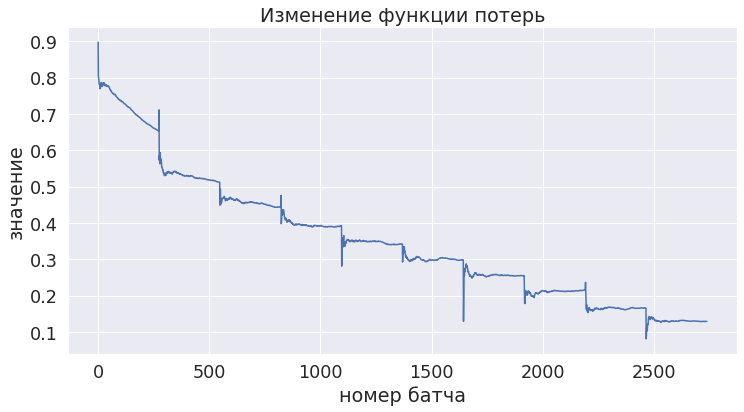

Номер эпохи: 10 | Время обучения эпохи: 0m 9s
	Train Loss: 0.129 | Train Acc: 95.30%
	 Val. Loss: 0.339 |  Val. Acc: 86.91%


In [ ]:
training_loop(model)

Посчитаем качество модели на тестовой выборке.

In [ ]:
model.load_state_dict(torch.load('tut4-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.308 | Test Acc: 87.07%


После лемматизации качество на тесте незначительно увеличилось (на семинаре качество теста) было 87.00%. 

## 2. Изменение размера эмбеддинга

Уменьшим размер эмбеддингов до 30. Как поменялось качество модели? 

*Замечание.* Если в предыдущем пункте вы перезаписали датасеты, применив к ним стемминг или лемматизацию, то их нужно скачать заново. 

In [10]:
TEXT = data.Field(tokenize='spacy', batch_first=True)
LABEL = data.LabelField(dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [11]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [12]:
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [13]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [14]:
EMBEDDING_DIM = 30  # размерность векторов-эмбеддингов
INPUT_DIM = len(TEXT.vocab)  # размер словаря
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [3, 4, 5]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга
model_30 = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [15]:
# print(f'Модель имеет {count_parameters(model_30):,} обучаемых параметров')
# print(f'Слой ембеддингов: {count_parameters(model_30.embedding):,} обучаемых параметров')
# print(f'Слои свёртки: {count_parameters(model_30.convs):,} обучаемых параметров')
# print(f'Линейный слой: {count_parameters(model_30.fc):,} обучаемых параметров')
model_30.eval()

CNN(
  (embedding): Embedding(25002, 30, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(30, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(30, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(30, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
optimizer = torch.optim.Adam(model_30.parameters())
criterion = nn.BCEWithLogitsLoss()
model_30 = model_30.to(device)
criterion = criterion.to(device)

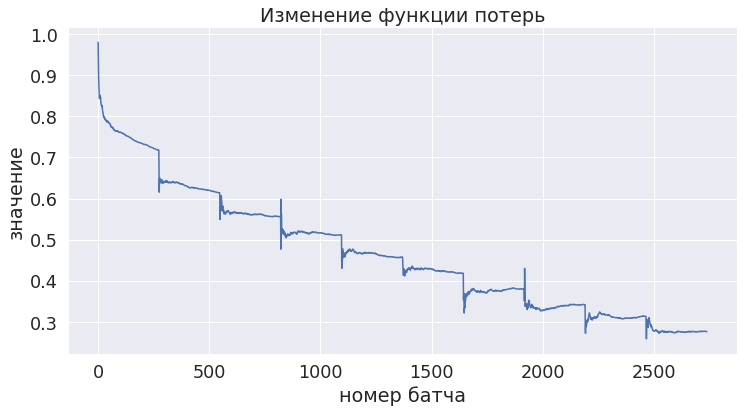

Номер эпохи: 10 | Время обучения эпохи: 0m 18s
	Train Loss: 0.276 | Train Acc: 88.55%
	 Val. Loss: 0.322 |  Val. Acc: 86.54%


In [17]:
training_loop(model_30, name_model='tut30-model.pt')

In [18]:
model_30.load_state_dict(torch.load('tut30-model.pt'))
test_loss, test_acc = evaluate(model_30, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.323 | Test Acc: 85.86%


Качество упало больше, чем на процент, при этом на трейне качество упало на 7 процентов. Это значит, что, скорее всего, 10 итераций нам не хватило, чтоб обучиться.

Теперь  увеличим размер эмбеддингов до 200. Как поменялось качество модели в сравнении с предыдущей? Какая модель более склонна к переобучению и почему?
Сделайте выводы.

In [ ]:
EMBEDDING_DIM = 200  # размерность векторов-эмбеддингов
INPUT_DIM = len(TEXT.vocab)  # размер словаря
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [3, 4, 5]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга
model_200 = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
print(f'Модель имеет {count_parameters(model_200):,} обучаемых параметров')
print(f'Слой ембеддингов: {count_parameters(model_200.embedding):,} обучаемых параметров')
print(f'Слои свёртки: {count_parameters(model_200.convs):,} обучаемых параметров')
print(f'Линейный слой: {count_parameters(model_200.fc):,} обучаемых параметров')
model_200.eval()

Модель имеет 5,241,001 обучаемых параметров
Слой ембеддингов: 5,000,400 обучаемых параметров
Слои свёртки: 240,300 обучаемых параметров
Линейный слой: 301 обучаемых параметров


CNN(
  (embedding): Embedding(25002, 200, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
optimizer = torch.optim.Adam(model_200.parameters())
criterion = nn.BCEWithLogitsLoss()
model_200 = model_200.to(device)
criterion = criterion.to(device)

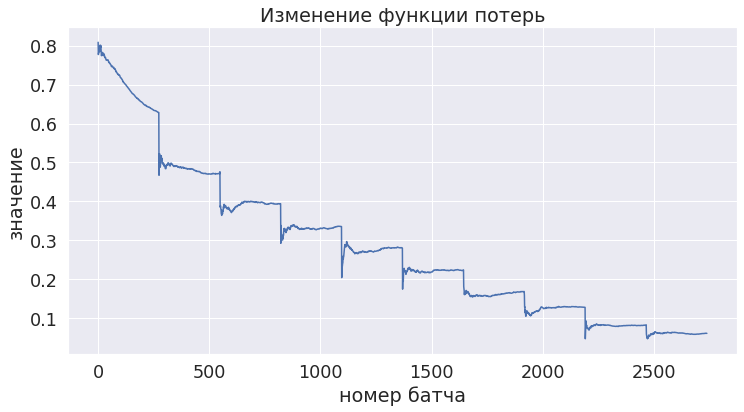

Номер эпохи: 10 | Время обучения эпохи: 0m 14s
	Train Loss: 0.060 | Train Acc: 97.90%
	 Val. Loss: 0.363 |  Val. Acc: 88.19%


In [ ]:
training_loop(model_200, name_model='tut200-model.pt')

In [ ]:
model_200.load_state_dict(torch.load('tut200-model.pt'))
test_loss, test_acc = evaluate(model_200, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.293 | Test Acc: 87.87%


Качество на тесте улучшилось почти на процент по сравнению с размером эмбеддинга 100. На трейне же качество улучшилось на 2 процента. Это значит, что мы за 10 итераций успели лучше обучиться.

## 3. Нахождение близких слов по эмбеддингам.
Напишите функцию, считающую cosine similarity между двумя векторами.

https://en.wikipedia.org/wiki/Cosine_similarity

In [19]:
def cosine_similarity(a, b):
    return np.nan_to_num(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)), nan=-1)

Напишите функцию, которая принимает на вход слово word и $k$ и возвращает $k$ наиболее похожих на word слов. 

Эмбеддинги для каждого слова должны быть получены с помощью матрицы эмбеддингов из Embedding слоя вашей модели. В качестве модели возьмите модель из предыдущего пункта с маленьким размером эмбеддинга. 

Чтобы по слову получить его индекс в словаре и обратно можно воспользоваться аттрибутами нашего словаря: `TEXT.vocab.stoi` и `TEXT.vocab.atoi`.


In [20]:
model_30.load_state_dict(torch.load('tut30-model.pt'))
model_30.eval()

CNN(
  (embedding): Embedding(25002, 30, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(30, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(30, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(30, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [21]:
len(TEXT.vocab)

25002

In [22]:
TEXT.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f465b4d8e90>>,
            {'<unk>': 0,
             '<pad>': 1,
             'the': 2,
             ',': 3,
             '.': 4,
             'and': 5,
             'a': 6,
             'of': 7,
             'to': 8,
             'is': 9,
             'in': 10,
             'I': 11,
             'it': 12,
             'that': 13,
             '"': 14,
             "'s": 15,
             'this': 16,
             '-': 17,
             '/><br': 18,
             'was': 19,
             'as': 20,
             'with': 21,
             'movie': 22,
             'for': 23,
             'film': 24,
             'The': 25,
             'but': 26,
             '(': 27,
             ')': 28,
             'on': 29,
             "n't": 30,
             'you': 31,
             'are': 32,
             'not': 33,
             'have': 34,
             'his': 35,
             'be': 36,
             'he': 37,
      

In [23]:
model_30.embedding.weight[2]

tensor([ 0.0332, -1.7908, -1.7769,  0.9122,  1.0020,  1.0111,  0.5661,  0.0024,
         0.2056, -0.9156,  0.1688,  0.6590,  0.1649, -0.2883, -2.1127,  0.8219,
         0.4184,  0.3082, -1.2227,  0.5810,  0.0932, -0.5603, -0.5682, -0.7482,
         0.2033,  0.0161, -0.5899,  0.1055,  0.7038, -1.1812], device='cuda:0',
       grad_fn=<SelectBackward>)

In [24]:
def find_all_embedings(TEXT=TEXT, model=model_30, batch_size=64):
    return model_30.embedding.weight.detach().cpu().numpy()

all_embedings = find_all_embedings()
all_embedings

array([[ 0.11742571, -0.7073654 ,  0.19396934, ...,  0.11884345,
        -1.0232571 ,  0.7304884 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03318829, -1.7908086 , -1.7769412 , ...,  0.10549283,
         0.7038105 , -1.1812453 ],
       ...,
       [ 1.1113755 ,  0.8843705 , -1.3177075 , ...,  0.56121314,
         0.42381832, -1.2979078 ],
       [ 0.1600528 , -0.09720878,  0.60695976, ..., -0.5353079 ,
        -0.41216958, -1.027637  ],
       [ 1.2530545 , -1.581203  , -0.91187733, ...,  0.65805626,
        -0.9136406 , -0.08518986]], dtype=float32)

In [25]:
def find_embeding_of_word(word, all_embedings=all_embedings):
    return all_embedings[TEXT.vocab.stoi[word]]

In [26]:
cosine_similarity(find_embeding_of_word('try'), find_embeding_of_word('try'))

1.0

In [27]:
len(TEXT.vocab)

25002

In [28]:
def find_most_similar(word, k=5, TEXT=TEXT, all_embedings=all_embedings, return_metric=False):
    cosine_metrics = []
    emb_word = find_embeding_of_word(word)
    for i in range(len(TEXT.vocab)):
        cur_word = TEXT.vocab.itos[i]
        emb_cur_word = find_embeding_of_word(cur_word)
        cosine_metrics.append(cosine_similarity(emb_word, emb_cur_word))

    k_top_indxs = np.argsort(cosine_metrics)[-k-1:-1]
    k_top_words = np.flip(np.array([(TEXT.vocab.itos[idx], cosine_metrics[idx]) for idx in k_top_indxs]))
    return k_top_words

Выберите несколько слов из словаря и посмотрите на их ближайшие по эмбеддингу 5 слов.

In [29]:
find_most_similar('great', 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


array([['0.6542249', 'fantastic'],
       ['0.635271', 'Gertrude'],
       ['0.63212425', 'yeon'],
       ['0.6318066', 'Juarez'],
       ['0.62777627', '/>For']], dtype='<U32')

In [30]:
find_most_similar('drama', 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


array([['0.6928256', 'see.<br'],
       ['0.62497246', 'Buddies'],
       ['0.6157206', 'penned'],
       ['0.60037595', 'yuppie'],
       ['0.59740615', 'ugh']], dtype='<U32')

In [31]:
find_most_similar('wife', 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


array([['0.6976279', 'end.<br'],
       ['0.68163574', 'within'],
       ['0.667831', 'racy'],
       ['0.62660766', 'noisy'],
       ['0.6189581', 'Duel']], dtype='<U32')

Видно, что близкие слова часто являются даже другими частями речи (причем часто для существительного близкие слова - прилагательные). Можно предположить, что это связано с тем, что у существительных и связанных с ними прилагательных высокая совстречаемость, а, видимо, эмбеддинг-слой работает как раз с совстречаемостью.

## 4. Эксперементы со свёртками.

Обучите модель с фильтрами меньших размеров: 1, 2 и 3. Измерьте ее качество.

In [ ]:
for i, x in tqdm(enumerate(train_data)):
    text = x.text
    train_data[i].text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]

print([train_data[0].text])

0it [00:00, ?it/s]

[['It', 'be', 'so', 'terrible', '.', 'It', 'be', "n't", 'fun', 'to', 'watch', 'at', 'all', '.', 'Even', 'the', 'scene', 'where', 'the', 'girl', 'be', 'use', 'a', 'vibrator', ',', 'even', 'that', "'s", 'not', 'fun', 'to', 'watch', 'in', 'this', 'movie', '.', 'I', 'say', 'again', ',', 'the', 'scene', 'where', 'a', 'girl', 'be', 'masturbate', 'with', 'a', 'vibrator', 'be', 'not', 'even', 'fun', 'to', 'watch', '.', 'Or', 'maybe', 'if', 'that', 'be', 'the', 'only', 'part', 'of', 'the', 'movie', 'that', 'you', 'watch', ',', 'just', 'girl', 'on', 'couch', 'use', 'a', 'vibrator', '.', 'Maybe', 'they', 'should', 'have', 'just', 'release', 'that', 'one', 'scene', 'in', 'theater', ',', 'maybe', 'then', 'the', 'movie', 'would', 'be', 'enjoyable', 'on', 'a', 'certain', 'level', '.', 'My', 'advice', ',', 'fast', 'forward', 'to', 'that', 'point', ',', 'watch', 'it', ',', 'rewind', 'the', 'movie', ',', 'watch', 'it', 'again', ',', 'rewind', ',', 'repeat', '.', 'Maybe', 'you', 'could', 'enjoy', 'yourse

In [ ]:
for i, x in tqdm(enumerate(valid_data)):
    text = x.text
    valid_data[i].text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]

print([valid_data[0].text])

0it [00:00, ?it/s]

[['The', 'beautiful', 'story', 'of', 'Stardust', 'be', 'write', 'by', 'by', 'Neil', 'Gaiman', '(', 'writer', 'of', 'MirrorMask', ')', 'and', 'it', "'s", 'really', 'a', 'good', 'story', '.', 'I', 'think', 'it', 'would', 'appeal', 'to', 'any', 'Labyrinth', ',', 'Princess', 'Bride', 'or', '10th', 'Kingdom', 'fan', 'and', 'yet', 'it', "'s", 'totally', 'unique', 'and', 'stand', 'up', 'on', 'it', "'s", 'own', '.', 'And', 'I', 'feel', 'the', 'film', 'adaptation', 'of', 'this', 'story', 'have', 'a', 'far', 'well', 'end', 'than', 'what', 'be', 'present', 'in', 'the', 'original', 'novel', 'by', 'Neil', 'Gaiman', '.', 'I', 'wo', "n't", 'spoil', 'it', 'for', 'you.<br', '/><br', '/>The', 'main', 'character', ',', 'Tristan', '(', 'Tristran', 'in', 'the', 'novel', ')', ',', 'be', 'the', 'son', 'of', 'a', 'mortal', 'and', 'a', 'faerie', 'slave', 'kept', 'by', 'a', 'witch', 'in', 'the', 'realm', 'of', 'faerie', '.', 'The', 'story', 'begin', 'in', 'a', 'town', 'near', 'a', 'wall', 'that', 'separate', 't

In [ ]:
for i, x in tqdm(enumerate(test_data)):
    text = x.text
    test_data[i].text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]

print([test_data[0].text])

0it [00:00, ?it/s]

[['The', 'other', 'reviewer', 'be', 'way', 'WAAAAY', 'off', 'a', 'to', 'why', 'the', 'Farscape', 'show', 'have', 'be', '(', 'temporarily', ')', 'put', 'to', 'rest', '.', 'It', 'have', 'NOTHING', 'to', 'do', 'with', 'the', 'quality', 'of', 'the', 'show', "'", 'slack', "'", '.', 'In', 'fact', ',', 'the', 'exact', 'OPPOSITE', 'be', 'true', '.', 'They', 'kept', 'get', 'well', 'and', 'well', '!', ':)', 'I', 'have', 'see', 'every', 'episode', 'and', 'when', 'you', 'simply', 'watch', 'them', 'in', 'order', 'you', 'really', 'become', 'in', 'awe', 'how', 'much', 'cooler', 'it', 'get', 'a', 'they', 'move', 'on', 'and', 'on', ',', 'and', 'the', 'wormhole', '&', 'Aeryn', 'subplots', 'be', 'really', 'very', 'interest', 'and', 'give', 'it', 'MORE', 'vibe', ',', 'not', 'less', '.', 'Before', 'it', 'be', 'sort', 'of', 'chaotic', ',', 'slow', ',', 'and', 'rather', 'aimless', '.', 'They', 'spent', 'like', 'the', 'first', 'two', 'season', 'run', 'from', 'this', 'foe', 'type', ',', 'but', 'in', 'the', 'se

In [ ]:
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [ ]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
INPUT_DIM = len(TEXT.vocab)  # размер словаря
EMBEDDING_DIM = 100  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [1, 2, 3]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга

model_1_2_3 = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
def count_parameters(model):
    ''' Подсчёт числа параметров модели '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Модель имеет {count_parameters(model_1_2_3):,} обучаемых параметров')
print(f'Слой ембеддингов: {count_parameters(model_1_2_3.embedding):,} обучаемых параметров')
print(f'Слои свёртки: {count_parameters(model_1_2_3.convs):,} обучаемых параметров')
print(f'Линейный слой: {count_parameters(model_1_2_3.fc):,} обучаемых параметров')
model_1_2_3.eval()

Модель имеет 2,560,801 обучаемых параметров
Слой ембеддингов: 2,500,200 обучаемых параметров
Слои свёртки: 60,300 обучаемых параметров
Линейный слой: 301 обучаемых параметров


CNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
optimizer = torch.optim.Adam(model_1_2_3.parameters())
criterion = nn.BCEWithLogitsLoss()
model_1_2_3 = model_1_2_3.to(device)
criterion = criterion.to(device)

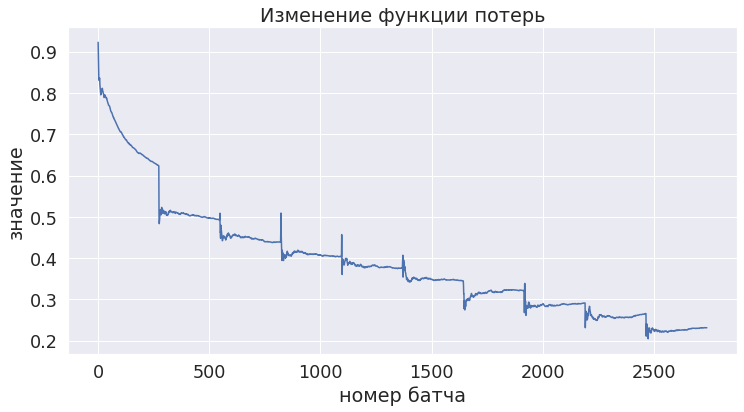

Номер эпохи: 10 | Время обучения эпохи: 0m 24s
	Train Loss: 0.231 | Train Acc: 90.59%
	 Val. Loss: 0.279 |  Val. Acc: 88.31%


In [ ]:
training_loop(model_1_2_3, name_model='tut_1_2_3-model.pt')

In [ ]:
model_1_2_3.load_state_dict(torch.load('tut_1_2_3-model.pt'))
test_loss, test_acc = evaluate(model_1_2_3, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.287 | Test Acc: 87.73%


Теперь рассмотрим лишь фильтры размера 1 и 2.

In [ ]:
INPUT_DIM = len(TEXT.vocab)  # размер словаря
EMBEDDING_DIM = 100  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [1, 2]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга

model_1_2 = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
print(f'Модель имеет {count_parameters(model_1_2):,} обучаемых параметров')
print(f'Слой ембеддингов: {count_parameters(model_1_2.embedding):,} обучаемых параметров')
print(f'Слои свёртки: {count_parameters(model_1_2.convs):,} обучаемых параметров')
print(f'Линейный слой: {count_parameters(model_1_2.fc):,} обучаемых параметров')
model_1_2.eval()

Модель имеет 2,530,601 обучаемых параметров
Слой ембеддингов: 2,500,200 обучаемых параметров
Слои свёртки: 30,200 обучаемых параметров
Линейный слой: 201 обучаемых параметров


CNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
  )
  (fc): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
optimizer = torch.optim.Adam(model_1_2.parameters())
criterion = nn.BCEWithLogitsLoss()
model_1_2 = model_1_2.to(device)
criterion = criterion.to(device)

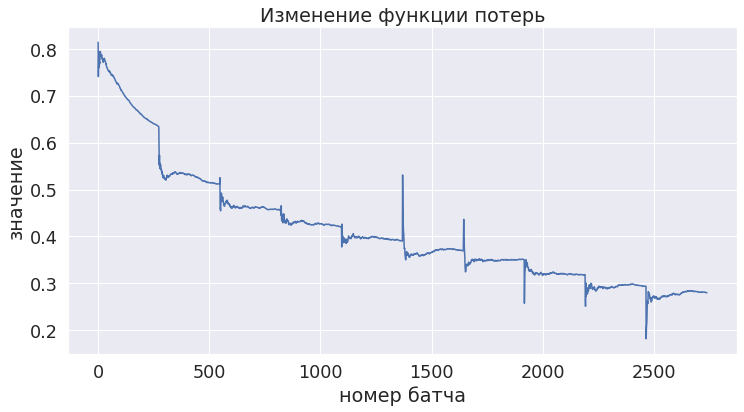

Номер эпохи: 10 | Время обучения эпохи: 0m 17s
	Train Loss: 0.280 | Train Acc: 88.07%
	 Val. Loss: 0.288 |  Val. Acc: 88.08%


In [ ]:
training_loop(model_1_2, name_model='tut_1_2-model.pt')

In [ ]:
model_1_2.load_state_dict(torch.load('tut_1_2-model.pt'))
test_loss, test_acc = evaluate(model_1_2, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.299 | Test Acc: 87.24%


Сильно ли меняется качество модели для данной задачи? Почему?

Качество на трейне сильно упало у обеих моделей, а вот на тесте модель с 3 слоями показывает себя очень неплохо, модель с двумя слоями несколько хуже. Видимо, модель с двумя слоями все-таки видит недостаточно связей слов, а модели с 3 слоями, но с маленьким размером фильтров уже хватает видимости, чтоб уловить нужные зависимости.

## 5. Аугментация данных.

Попробуйте сделать аугментацию текста. 

Замените слово на синоним с некоторой вероятностью $p$. То есть с вероятностью $p$ каждое слово будет заменено на некоторый его синоним, а с вероятностью $1 - p$ слово останется как есть.

Обучите модель на таких данных и посмотрите на качество.

In [56]:
TEXT = data.Field(tokenize='spacy', batch_first=True)
LABEL = data.LabelField(dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
Exception ignored in: <function tqdm.__del__ at 0x7fd82a18edd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/tqdm/notebook.py", line 290, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7fd82a18edd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close(

In [57]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


Сделаем матрицу синонимов, чтобы не ждать долго постоянного обращения к функциям из 3-го пункта.

In [32]:
w_matrix = find_all_embedings()
w_matrix[2:10].shape

(8, 30)

In [33]:
np.linalg.norm(w_matrix[2:], axis=1)

array([4.6622276, 5.993986 , 4.784254 , ..., 5.022842 , 5.0818906,
       5.618357 ], dtype=float32)

In [34]:
idxes = np.random.choice(np.linspace(2, 25001, 25000, dtype=int), replace=False, size=5000)
idxes

array([ 1276, 11572,  4016, ...,  9180, 17635,  3009])

In [35]:
w_matrix[idxes].shape

(5000, 30)

In [36]:
for w in w_matrix:
    print(w.shape)
    break

(30,)


In [37]:
synonim_matrix = []
for w in tqdm(w_matrix):
    cosines = np.nan_to_num(w @ w_matrix.T / (np.linalg.norm(w).reshape(-1, 1) @ np.linalg.norm(w_matrix, axis=1).reshape(1, -1)))
    k_top_indxs = np.argsort(cosines.reshape(-1))[-6:-1]
    synonim_matrix.append(np.flip(np.array([TEXT.vocab.itos[idx] for idx in k_top_indxs])).tolist())

synonim_matrix

  0%|          | 0/25002 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


[['Mononoke', 'Eggar', 'Hum', 'loaded', 'signals'],
 ['hinted', 'conveying', 'creations', 'customers', 'defining'],
 ['spins', 'edgy', 'Capshaw', 'although', 'pictures'],
 ['Randolph', 'ignores', 'brightness', 'Pikachu', 'pepper'],
 ['collaborator', 'Shredder', 'detectives', 'Ali', 'toss'],
 ['depiction', 'reconstruction', 'CHILDREN', 'driving', 'Band'],
 ['Warners', 'Bueller', 'Cliffhanger', 'maestro', 'Bibbidi'],
 ['catatonic', 'physically', 'Werewolf', 'adoring', 'demanding'],
 ['contend', 'Full', 'convinced', 'strands', 'posts'],
 ['horseback', 'collapses', '/>Tim', 'files', 'devastating'],
 ['holier', 'global', 'seduction', 'capped', 'Epps'],
 ['Bullet', 'convention', 'downs', '/>it', 'trusted'],
 ['china', 'intellect', 'critics', 'Kristine', 'recently'],
 ['Schrader', 'badly', 'Minister', 'inevitable', 'chicken'],
 ['Clue', 'Moreau', 'Mantegna', 'Sachar', 'simpleton'],
 ['Die', 'persons', 'realistic', 'ambiguous', 'Pony'],
 ['Chess', 'rant', 'abhorrent', '@', 'entering'],
 ['rags

In [ ]:
for i, data in tqdm(enumerate(train_data)):
    text = data.text
    print(text)
    break

0it [00:00, ?it/s]

['It', 'was', 'so', 'terrible', '.', 'It', 'was', "n't", 'fun', 'to', 'watch', 'at', 'all', '.', 'Even', 'the', 'scene', 'where', 'the', 'girl', 'is', 'using', 'a', 'vibrator', ',', 'even', 'that', "'s", 'not', 'fun', 'to', 'watch', 'in', 'this', 'movie', '.', 'I', 'say', 'again', ',', 'the', 'scene', 'where', 'a', 'girl', 'is', 'masturbating', 'with', 'a', 'vibrator', 'is', 'not', 'even', 'fun', 'to', 'watch', '.', 'Or', 'maybe', 'if', 'that', 'was', 'the', 'only', 'part', 'of', 'the', 'movie', 'that', 'you', 'watched', ',', 'just', 'girl', 'on', 'couch', 'using', 'a', 'vibrator', '.', 'Maybe', 'they', 'should', 'have', 'just', 'released', 'that', 'one', 'scene', 'in', 'theaters', ',', 'maybe', 'then', 'the', 'movie', 'would', 'be', 'enjoyable', 'on', 'a', 'certain', 'level', '.', 'My', 'advice', ',', 'fast', 'forward', 'to', 'that', 'point', ',', 'watch', 'it', ',', 'rewind', 'the', 'movie', ',', 'watch', 'it', 'again', ',', 'rewind', ',', 'repeat', '.', 'Maybe', 'you', 'could', 'enj

In [55]:
def make_augmentation(p=0):
    for i, data in enumerate(tqdm(train_data)):
        new_text = []
        text = data.text
        need_aug = sps.bernoulli(p).rvs(len(text))
        random_idx_syn = np.random.randint(low=0, high=4, size=len(text))
        for j, word in enumerate(text):
            if need_aug[j]:
                new_text.append(synonim_matrix[j][random_idx_syn[j]])
            else:
                new_text.append(word)
        train_data[i].text = new_text
    return train_data

In [56]:
train_data = make_augmentation(p=0.2)
train_data[0].text

  0%|          | 0/17500 [00:00<?, ?it/s]

['It',
 'was',
 'so',
 'terrible',
 '.',
 'reconstruction',
 'was',
 "n't",
 'convinced',
 'to',
 'watch',
 'at',
 'all',
 '.',
 'Even',
 'the',
 'scene',
 'where',
 'the',
 'substantive',
 'is',
 'using',
 'a',
 'vibrator',
 ',',
 'even',
 'that',
 "'s",
 'not',
 'fun',
 'to',
 'watch',
 'in',
 'this',
 'movie',
 'peer',
 'I',
 'say',
 'again',
 ',',
 'the',
 'scene',
 'fantasies',
 'aforementioned',
 'girl',
 'is',
 'masturbating',
 'with',
 'a',
 'vibrator',
 'is',
 'not',
 'even',
 'fun',
 'ovation',
 'watch',
 '.',
 'Or',
 'relied',
 'if',
 'Gage',
 'was',
 'the',
 'deceit',
 'part',
 'Features',
 'the',
 'movie',
 'that',
 'you',
 'watched',
 ',',
 'rapper',
 'girl',
 'VCR',
 'couch',
 'using',
 'a',
 'vibrator',
 '.',
 'Maybe',
 'they',
 'should',
 'epidemic',
 'just',
 'FULL',
 'that',
 'one',
 'scene',
 'in',
 'theaters',
 ',',
 'maybe',
 'then',
 'the',
 'movie',
 'groom',
 'be',
 'enjoyable',
 'on',
 'a',
 'certain',
 'level',
 '.',
 'My',
 'advice',
 ',',
 'fast',
 'forward

Теперь обучим модель на аугментированном трейне и посмотрим, что получится.

In [57]:
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [58]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [68]:
INPUT_DIM = len(TEXT.vocab)  # размер словаря
EMBEDDING_DIM = 100  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [3, 4, 5]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [69]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

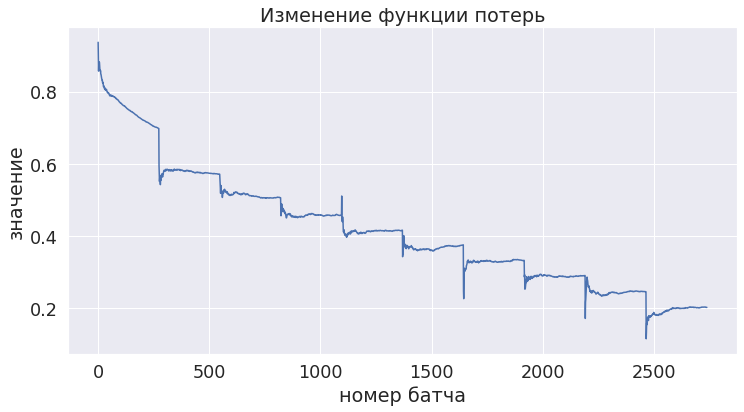

Номер эпохи: 10 | Время обучения эпохи: 0m 33s
	Train Loss: 0.202 | Train Acc: 91.91%
	 Val. Loss: 0.326 |  Val. Acc: 86.99%


In [70]:
training_loop(model, name_model='tut_aug-model.pt')

In [71]:
model.load_state_dict(torch.load('tut_aug-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.327 | Test Acc: 86.00%


Качество на тесте по сравнению с моделью с семинара упало почти на процент, при этом качество на трейне упало больше, чем на 3 процента. Это может значить, что мы недообучились на аугментированных данных, то есть, времени на обучение под аугментированные данные нужно больше, чем не под аугментированные.